In [2]:
%pylab inline
import matplotlib.pyplot

import numpy as np
import scipy.linalg
from sklearn import metrics
import pickle

Populating the interactive namespace from numpy and matplotlib


# (a+b) download and segment data

In [3]:
data = np.load("cs189_image_features.npz")
metadata = pickle.load(open("metadata.pkl","rb"))
X_0 = data["X"]
y_0 = data["Y"]
# acc = 1
# inacc = -1
y_0 = (y_0*2) - 1    
data.keys()

['X', 'Y', 'ids']

In [4]:
wrong_ids= []
for m in metadata:
    try:(float(m['lat']), float(m['lon'])) 
    except: 
        wrong_ids.append(m['id'])
        
ok_ids = list(range(len(metadata)))
[ok_ids.remove(x) for x in wrong_ids];     
assert len(ok_ids) + len(wrong_ids) == len(metadata)
print("removed {0} points b/c latlon could not be converted to a float".format(len(wrong_ids)))
# The following two lines ensure that X and y now contain only points with valid latlons
X = X_0[ok_ids]
y = y_0[ok_ids]
# The following two lines does the same thing for latlons and submission ID.
latlons = np.array([[metadata[idx]['lat'],metadata[idx]['lon']] for idx in ok_ids]).astype(float64)
submission_ids = np.array([metadata[idx]['submission_id'] for idx in ok_ids])

removed 89 points b/c latlon could not be converted to a float


# (c) train a model

In [5]:
val_set_number = 3000

np.random.seed(0)
idxs = np.random.choice(X.shape[0], X.shape[0], replace=False)
train_idxs = idxs[:val_set_number]
test_idxs = idxs[val_set_number:]

X_train = X[train_idxs]
y_train = y[train_idxs]
X_test = X[test_idxs]
y_test = y[test_idxs]
latlons_train = latlons[train_idxs]
latlons_test = latlons[test_idxs]
submission_ids_train = submission_ids[train_idxs]
submission_ids_test = submission_ids[test_idxs]
XTX = X_train.T.dot(X_train)
XTy = X_train.T.dot(y_train)

model = scipy.linalg.solve(XTX + 0*np.eye(XTX.shape[0]), XTy)
y_train_pred = X_train.dot(model)
y_test_pred = X_test.dot(model)


train_acc = metrics.accuracy_score(np.sign(y_train_pred), y_train)
test_acc = metrics.accuracy_score(np.sign(y_test_pred), y_test)
train_roc_score = metrics.roc_auc_score(y_train, y_train_pred)
test_roc_score = metrics.roc_auc_score(y_test, y_test_pred)

print(f"Train Acc: {train_acc}, Train ROC: {train_roc_score}")
print(f"Test Acc: {test_acc}, Test ROC: {test_roc_score}")

Train Acc: 0.8393333333333334, Train ROC: 0.9158513711720522
Test Acc: 0.7503939489442168, Test ROC: 0.8265623309348835


FPR of t=0 is 0.255 
TPR of t=0 is 0.755


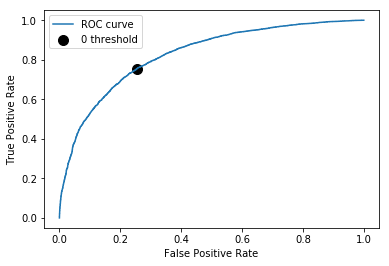

In [6]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_test_pred)
plt.plot(fpr, tpr, label="ROC curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

zero_idx = np.argmin(np.abs(thresholds - np.zeros_like(thresholds)))
thresholds[zero_idx]
print("FPR of t=0 is {0:.3} \nTPR of t=0 is {1:.3}".format(fpr[zero_idx], tpr[zero_idx]))

plt.scatter(fpr[zero_idx], tpr[zero_idx],s=100, color='black', label="0 threshold")

plt.legend()

In [7]:
X.shape

(15692, 512)

# (c) evaluate model performance as number of training points changes

In [10]:
val_set_number = 3000

np.random.seed(0)

val_accs_num_train = []
num_train_points_to_try = [1000,1500,2000,3000,4000,6000,8000,10000,11000,12000]
for num_train_points in num_train_points_to_try:
    # use idxs from before, which are already shuffled
    train_idxs = idxs[:val_set_number][:num_train_points]
    
    X_train = X[train_idxs][:num_train_points]
    y_train = y[train_idxs][:num_train_points]

    XTX = X_train.T.dot(X_train)
    XTy = X_train.T.dot(y_train)

    model = scipy.linalg.solve(XTX + 1e-4*np.eye(XTX.shape[0]), XTy)
    y_train_pred = X_train.dot(model)
    y_test_pred = X_test.dot(model)


    train_acc = metrics.accuracy_score(np.sign(y_train_pred), y_train[:num_train_points])
    test_acc = metrics.accuracy_score(np.sign(y_test_pred), y_test)
    train_roc_score = metrics.roc_auc_score(y_train[:num_train_points], y_train_pred)
    test_roc_score = metrics.roc_auc_score(y_test, y_test_pred)

    val_accs_num_train.append(test_acc)
    

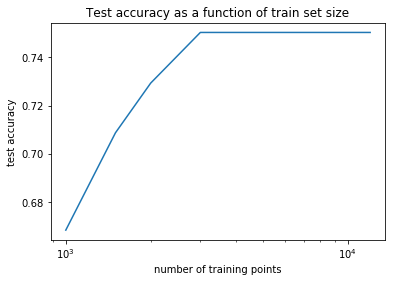

In [11]:
plt.plot(num_train_points_to_try, val_accs_num_train)
plt.xscale("log")
#plt.yscale("log")
plt.xlabel("number of training points")
plt.ylabel("test accuracy")
plt.title("Test accuracy as a function of train set size")

# (d) errors over space

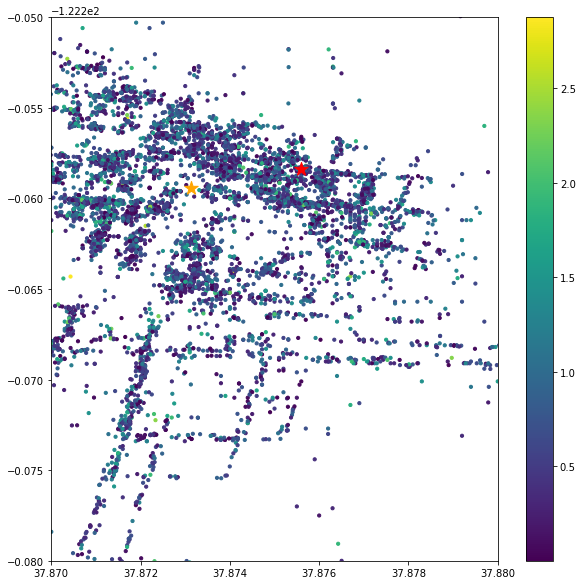

In [12]:
# SPATIAL SCATTER
fig, ax = plt.subplots(figsize=(10,10))
plt.scatter(latlons_test[:,0],latlons_test[:,1], c=np.abs(y_test_pred-y_test),s=10)
#plt.xlim(37.86,37.88)
#plt.ylim(-122.28,-122.25)
plt.xlim(37.87,37.88)
plt.ylim(-122.28,-122.25)
plt.colorbar()
plt.scatter(37.875587, -122.258352,marker="*",c='red',s=200)
plt.scatter(37.873118, -122.259441 ,marker="*",c='orange',s=200)
#plt.scatter(np.median(latlons[:,0]), np.median(latlons[:,1]),marker="*",c="purple",s=300)

In [13]:
np.median(latlons[:,0]), np.median(latlons[:,1])

(37.871704444444447, -122.2595)